In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 completed with Loss: 0.6900043144822121, Accuracy: 0.52
Validation Loss: 0.6805730283260345, Validation Accuracy: 0.48
Epoch 2 completed with Loss: 0.6698275551199913, Accuracy: 0.62
Validation Loss: 0.6572099328041077, Validation Accuracy: 0.53
Epoch 3 completed with Loss: 0.6518571943044662, Accuracy: 0.685
Validation Loss: 0.62832590341568, Validation Accuracy: 0.82
Epoch 4 completed with Loss: 0.6306028231978417, Accuracy: 0.7
Validation Loss: 0.6052049458026886, Validation Accuracy: 0.82
Epoch 5 completed with Loss: 0.6125124931335449, Accuracy: 0.76
Validation Loss: 0.5842340737581253, Validation Accuracy: 0.83
Epoch 6 completed with Loss: 0.591057474911213, Accuracy: 0.765
Validation Loss: 0.5696064114570618, Validation Accuracy: 0.81
Epoch 7 completed with Loss: 0.5694788821041584, Accuracy: 0.78
Validation Loss: 0.5454216480255127, Validation Accuracy: 0.81
Epoch 8 completed with Loss: 0.5579096876084805, Accuracy: 0.785
Validation Loss: 0.5308629512786865, Validation 

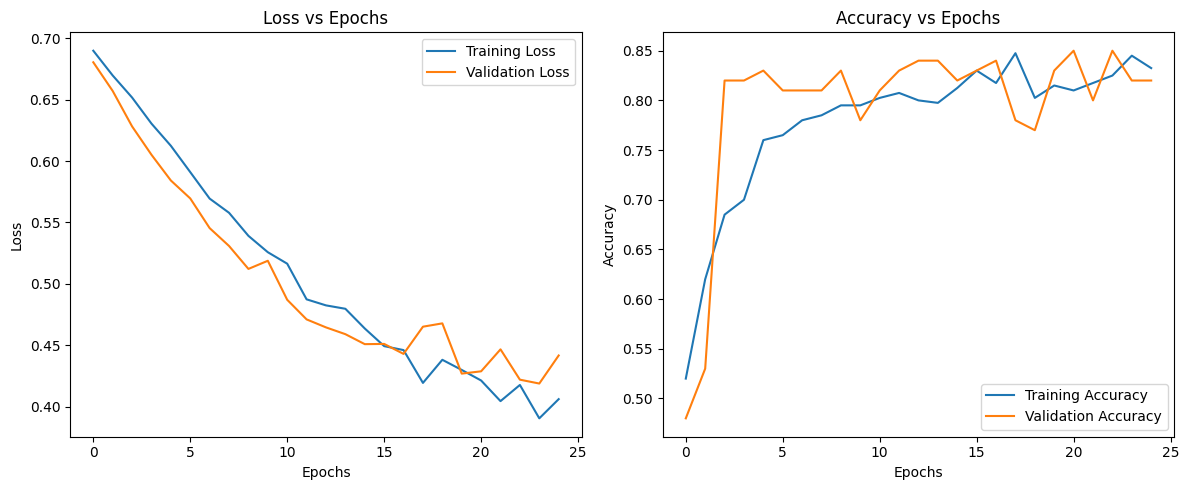

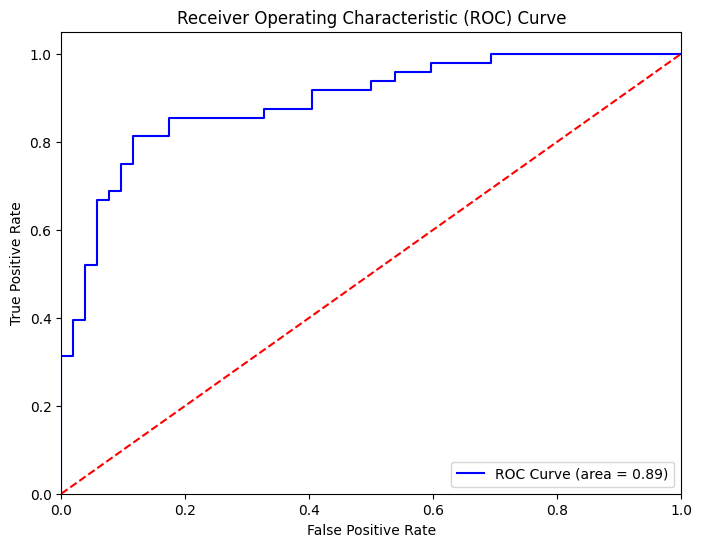

Training, Evaluation, and ROC Curve Plotting Completed!


In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Load IMDB dataset
dataset = load_dataset("imdb")

# Get 500 random reviews for training and validation
train_reviews = dataset['train']
random_indices = random.sample(range(len(train_reviews)), 500)
train_sample = train_reviews.select(random_indices)

# Split into train and validation sets (80-20 split)
train_test_split = train_sample.train_test_split(test_size=0.2)
train_data = train_test_split['train']
val_data = train_test_split['test']

# Tokenize Data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create DataLoader
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=10)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=10)

# Load Pretrained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Freeze layers to speed up training
for param in model.distilbert.parameters():
    param.requires_grad = False

# Set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Move model to device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training Loop
epochs = 25
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Calculate training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    # Calculate training metrics
    train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1} completed with Loss: {train_loss}, Accuracy: {train_accuracy}')

    # Validation Loop
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)

            # Store labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"])
print("Classification Report:\n", report)

# Calculate ROC AUC score for the validation set
y_true = all_labels
y_scores = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        y_scores.extend(torch.softmax(logits, dim=-1)[:, 1].cpu().numpy())  # Probability of positive class

roc_auc = roc_auc_score(y_true, y_scores)
print(f'ROC AUC Score: {roc_auc}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Training, Evaluation, and ROC Curve Plotting Completed!")


In [ ]:
# Save the model and tokenizer
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')

print("Model and tokenizer saved successfully!")

# Plotting the training and validation metrics

Model and tokenizer saved successfully!
